# Fitting Curly's sphere in water sims
in order to check consistency with my simulations

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl

In [6]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)
## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib
from misloc_mispol_package.parameterize import spec_fit as spit

## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [7]:
def label_offset(ax, axis="y"):
    if axis == "y":
        fmt = ax.yaxis.get_major_formatter()
        ax.yaxis.offsetText.set_visible(False)
        set_label = ax.set_ylabel
        label = ax.get_ylabel()

    elif axis == "x":
        fmt = ax.xaxis.get_major_formatter()
        ax.xaxis.offsetText.set_visible(False)
        set_label = ax.set_xlabel
        label = ax.get_xlabel()

    def update_label(event_axes):
        offset = fmt.get_offset()
        if offset == '':
            set_label("{}".format(label))
        else:
            set_label("{} ({})".format(label, offset))
        return

    ax.callbacks.connect("ylim_changed", update_label)
    ax.callbacks.connect("xlim_changed", update_label)
    ax.figure.canvas.draw()
    update_label(None)
    return


In [8]:
pixel_num = 300
boundary_pixel_coords_in_nm = [
    -750,
    750,
    -750,
    750,
    ]
pixel_size = (
    boundary_pixel_coords_in_nm[1] - boundary_pixel_coords_in_nm[0]
    )/(pixel_num)

exp_obs_pts = diffi.observation_points(
    boundary_pixel_coords_in_nm[0]*cm_per_nm, 
    boundary_pixel_coords_in_nm[1]*cm_per_nm, 
    boundary_pixel_coords_in_nm[2]*cm_per_nm, 
    boundary_pixel_coords_in_nm[3]*cm_per_nm, 
    300,) ## cm_per_m

img_extent = [
    boundary_pixel_coords_in_nm[0] - .5*pixel_size,
    boundary_pixel_coords_in_nm[1] + .5*pixel_size,
    boundary_pixel_coords_in_nm[2] - .5*pixel_size,
    boundary_pixel_coords_in_nm[3] + .5*pixel_size,
]

In [9]:
path_to_data = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'from_Biteen_group',
    'simple_sphere_sims_011720',
    'reanysimulationyouwantmetodo'
    )

I guess the first thing I should do is compare Curly's sphere spectrum the the one I have been using. I might need to find my JC spec. 

In [11]:
## Load Curl's spectrum
import h5py

AuND_D80_scat_Spectra = {}
f = h5py.File(
    os.path.join(path_to_data, "AuND_D80_scat_Spectra.mat"), 
    'r')

for key, val in f.items():
    AuND_D80_scat_Spectra[key] = np.array(val)[0]

In [22]:
## Get my spectrum 
path_to_spec = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'MATLAB',
    'sphere_dip_spectrum',
    )

curly_sphere_spec = sio.loadmat(os.path.join(
    path_to_spec,
    'sph_scat_spec.mat'
    ))
## Convert to eV and plot spectra 
my_hw = 1240/curly_sphere_spec['enei'][0]
my_spec = curly_sphere_spec['sca']

# plt.figure(figsize=(2,1.5), dpi=150)
# for i, spectrum in enumerate(spec.T):
#     plt.plot(hw, spectrum)
# plt.xlabel('eV')
# plt.ylabel('$\mathrm{nm}^2$')
# plt.title('JC Sphere Scattering')

In [13]:
## Check key names in loaded Curly spectrum file
AuND_D80_scat_Spectra.keys()

dict_keys(['f', 'source_intensity', 'source_power', 'transabsorp', 'transscat'])

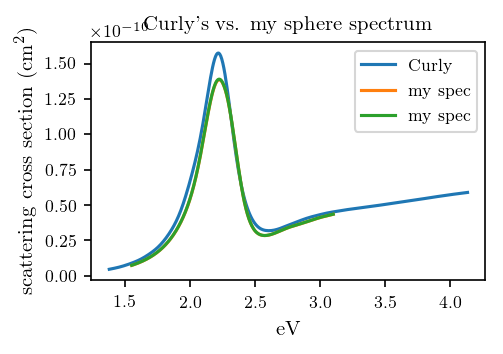

In [38]:
## Plot Curly's sphere spectrum
sigma_scat_data = (
    AuND_D80_scat_Spectra['transscat'] 
    * AuND_D80_scat_Spectra['source_power']
    / AuND_D80_scat_Spectra['source_intensity']
    )

curly_hw = hbar * 2 * np.pi * AuND_D80_scat_Spectra['f']

## rescale Curly's spec to cm^2
cmsqrd_on_msqrd = (100)**2
curly_spec = sigma_scat_data * cmsqrd_on_msqrd

## Rescale my spec to cm^2
cmsqrd_on_nmsqrd = (1e-7)**2.
my_spec_nm2 = my_spec * cmsqrd_on_nmsqrd

plt.figure(dpi=150)
plt.plot(curly_hw, curly_spec, label='Curly')
plt.xlabel('eV')
plt.ylabel('scattering cross section ($\mathrm{cm}^2$)')
plt.title("Curly's vs. my sphere spectrum")

for i, spectrum in enumerate(my_spec_nm2.T):
    plt.plot(my_hw, spectrum, label='my spec')

plt.legend()

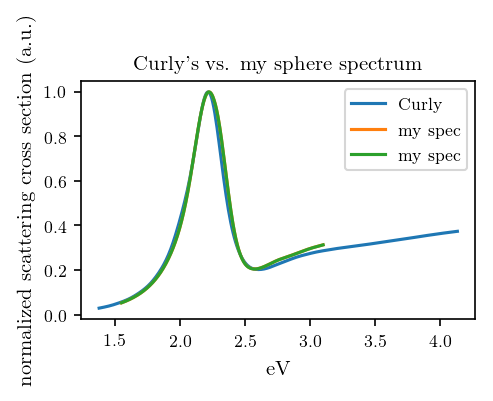

In [41]:
plt.figure(dpi=150)
plt.plot(curly_hw, curly_spec/curly_spec.max(), label='Curly')
plt.xlabel('eV')
plt.ylabel('normalized scattering cross section (a.u.)')
plt.title("Curly's vs. my sphere spectrum")

for i, spectrum in enumerate(my_spec_nm2.T):
    plt.plot(my_hw, spectrum/spectrum.max(), label='my spec')

plt.legend()